# Time Series Analysis, Time Series Forecasting, and Neural Networks

This notebook provides a comprehensive introduction to time series analysis and forecasting. We will cover the following topics:

1.  **Stationarity in Time Series**
    * What is Stationarity?
    * Visual Indicators of Stationarity
    * Statistical Test of Stationarity (the Augmented Dickey-Fuller Test)
2.  **Forecasting Techniques**
    * Exponential Smoothing (Simple, Double, and Triple)
    * ARIMA
    * SARIMA
    * LSTM Neural Networks
3.  **Model Comparison**
4.  **Saving Predictions**

## 1. Stationarity in Time Series

## In-Built Stationarizing Mechanism in Time Series Forecasting Algorithms
1. **❌Exponential Smoothing (Simple, Double [Holt], and Triple [Holt-Winters])**
- Exponential Smoothing techniques do not require the series to be stationary.
- Instead, they explicitly model components such as trend and seasonality directly.
- They handle non-stationarity by design, rather than transforming the data to a stationary form.

2. **✅ARIMA (AutoRegressive Integrated Moving Average)**
- ARIMA explicitly includes differencing (the "I" in ARIMA) as part of the model to make the series stationary.
- You specify the `d` parameter in `ARIMA(p, d, q)`, where:
  - `d = 1` tells the model to difference the data once. This step transforms a non-stationary series into a stationary one internally.

3. **✅SARIMA (Seasonal ARIMA)**
- SARIMA extends ARIMA with seasonal differencing.
- It uses two differencing parameters:
  - `d` for non-seasonal differencing,
  - `D` for seasonal differencing over a defined period m.
- Therefore, SARIMA also has built-in mechanisms to induce both stationarity and seasonal stationarity.

4. **❌LSTM (Long Short-Term Memory Networks)**
- LSTM models do not have explicit stationarizing mechanisms.
- They learn directly from raw sequences, even if they are non-stationary.
- However, data preprocessing such as normalization and differencing often improves performance.
- LSTMs can model complex non-linear and non-stationary behavior, but they do not automatically make the data stationary.

## 2. Time Series Forecasting Techniques

## Step 1: Import Libraries

In [31]:
# For file and system operations
import urllib.request
from pathlib import Path
import os

# For data manipulation
import pandas as pd
import pandas_datareader as pdr
import datetime as dt
import re

# For data visualization
import matplotlib.pyplot as plt

import mplfinance as mpf
import yfinance as yf

# For time series analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# For suppressing warnings
import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

# Ensures that matplotlib plots are displayed directly within the notebook,
# right below the code cell that produces them. It makes visualizations appear
# inline for easier viewing and analysis.
%matplotlib inline

## Step 2: Load and Preprocess/Clean the Data

### Load the Data

In [2]:
dataset_path = './data/stockprice_cleaned.csv'

if not os.path.exists(dataset_path):
    print("❌ Please create the dataset first using the previous Jupyter Notebook.")
else:
    print("✅ Dataset exists locally")

data = pd.read_csv(dataset_path, encoding='utf-8', nrows=200000)

✅ Dataset exists locally


### Preprocess/Clean the Data

In [3]:
# 1) Ensure datetime index and sorted

# This line converts the `Date` column in the `data` DataFrame to datetime
# objects. The `errors="coerce"` argument means that any value that cannot
# be parsed as a date will be replaced with `NaT` (Not a Time), which is
# pandas' way of marking missing or invalid dates. This helps prevent errors
# from invalid date formats and ensures the column is consistently typed.
if "Date" in data.columns:
    data["Date"] = pd.to_datetime(data["Date"], errors="coerce")
    data = data.set_index("Date")

data = data.sort_index()

# 2) Normalize column names (trim, unify, and fix common naming)
data.columns = [c.strip() for c in data.columns]
rename_map = {
    "Close/Last": "Close",
    "Adj Close": "Close",
    "Adj. Close": "Close",
    "Closing Price": "Close",
    "Open Price": "Open",
    "Opening Price": "Open",
    "High Price": "High",
    "Low Price": "Low",
    "Trade Volume": "Volume",
    "Volume (Shares)": "Volume",
    "Total Volume": "Volume",
    "High/Low": "High",
    "Low/High": "Low"
}
data = data.rename(columns=rename_map)

# 3) Define a helper to strip non-numeric characters (keep digits, dot, minus)
def to_numeric_str(s: str) -> str:
    # Handle None/NaN safely
    s = "" if s is None else str(s)
    # Strip any characters except digits, decimal point, minus
    return re.sub(r"[^0-9.\-]", "", s)

# 4) Coerce OHLC to float
ohlc_cols = [c for c in ["Open", "High", "Low", "Close"] if c in data.columns]
for c in ohlc_cols:
    data[c] = pd.to_numeric(data[c].astype(str).map(to_numeric_str), errors="coerce")

# 5) Coerce Volume to numeric (basic version: strip non-numeric)
if "Volume" in data.columns:
    data["Volume"] = pd.to_numeric(data["Volume"].astype(str).map(to_numeric_str), errors="coerce")

# Optional: if your Volume has K/M/B suffixes (e.g., 12K, 3.5M, 1.2B) and you want correct scaling:
def parse_volume(v):
    v = str(v).strip()
    if not v or v.lower() == "nan":
        return float("nan")
    mult = 1
    if v[-1] in "KkMmBb":
        suffix = v[-1].upper()
        v = to_numeric_str(v[:-1])
        mult = {"K": 1_000, "M": 1_000_000, "B": 1_000_000_000}[suffix]
    else:
        v = to_numeric_str(v)
    return float(v) * mult if v else float("nan")
if "Volume" in data.columns:
    data["Volume"] = data["Volume"].map(parse_volume)

# 6) Drop rows where any of OHLC are missing (mplfinance needs valid OHLC rows)
if ohlc_cols:
    data = data.dropna(subset=ohlc_cols)

### Confirm Cleaned Data

In [4]:
print("\n*1* The number of observations and variables")
display(data.shape)

print("\n*2* The data types:")
display(data.info())


*1* The number of observations and variables


(431, 5)


*2* The data types:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 431 entries, 2024-01-02 to 2025-09-19
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   431 non-null    float64
 1   High    431 non-null    float64
 2   Low     431 non-null    float64
 3   Open    431 non-null    float64
 4   Volume  431 non-null    float64
dtypes: float64(5)
memory usage: 20.2 KB


None

In [5]:
print("\n*3* The summary of the numeric columns:")
display(data.describe())

print("\n*4* The whole dataset:")
display(data)

print("\n*5* The first 5 rows in the dataset:")
display(data.head())

print("\n*6* The last 5 rows in the dataset:")
display(data.tail())


*3* The summary of the numeric columns:


,Close,High,Low,Open,Volume
count,431.000000,431.000000,431.000000,431.000000,4.310000e+02
mean,121.713768,123.789721,119.355524,121.710775,3.179630e+08
std,31.150478,31.312787,30.972236,31.244267,1.566088e+08
min,47.545158,48.159848,47.296283,47.461201,1.051570e+08
25%,102.242134,105.726694,98.895399,103.481977,1.983376e+08
50%,123.494026,125.004154,120.023859,123.073191,2.739120e+08
75%,140.025940,141.834105,137.740247,139.974509,4.098736e+08
max,183.149673,184.469591,180.579807,182.949688,1.142269e+09



*4* The whole dataset:


,Close,High,Low,Open,Volume
Date,,,,,
2024-01-02,48.143856,49.270290,47.571145,49.219317,411254000.0
2024-01-03,47.545158,48.159848,47.296283,47.461201,320896000.0
2024-01-04,47.973946,48.475693,47.484190,47.743059,306535000.0
2024-01-05,49.072388,49.522163,48.281784,48.437708,415039000.0
2024-01-08,52.226810,52.248803,49.454202,49.487187,642510000.0
...,...,...,...,...,...
2025-09-15,177.750000,178.850006,174.509995,175.669998,147061600.0
2025-09-16,174.880005,177.500000,174.380005,177.000000,140737800.0
2025-09-17,170.289993,173.199997,168.410004,172.639999,211843800.0



*5* The first 5 rows in the dataset:


,Close,High,Low,Open,Volume
Date,,,,,
2024-01-02,48.143856,49.270290,47.571145,49.219317,411254000.0
2024-01-03,47.545158,48.159848,47.296283,47.461201,320896000.0
2024-01-04,47.973946,48.475693,47.484190,47.743059,306535000.0
2024-01-05,49.072388,49.522163,48.281784,48.437708,415039000.0
2024-01-08,52.226810,52.248803,49.454202,49.487187,642510000.0



*6* The last 5 rows in the dataset:


,Close,High,Low,Open,Volume
Date,,,,,
2025-09-15,177.750000,178.850006,174.509995,175.669998,147061600.0
2025-09-16,174.880005,177.500000,174.380005,177.000000,140737800.0
2025-09-17,170.289993,173.199997,168.410004,172.639999,211843800.0
2025-09-18,176.240005,177.100006,172.960007,173.979996,191763300.0
2025-09-19,176.669998,178.080002,175.179993,175.770004,236658800.0


## Step 3: Forecast

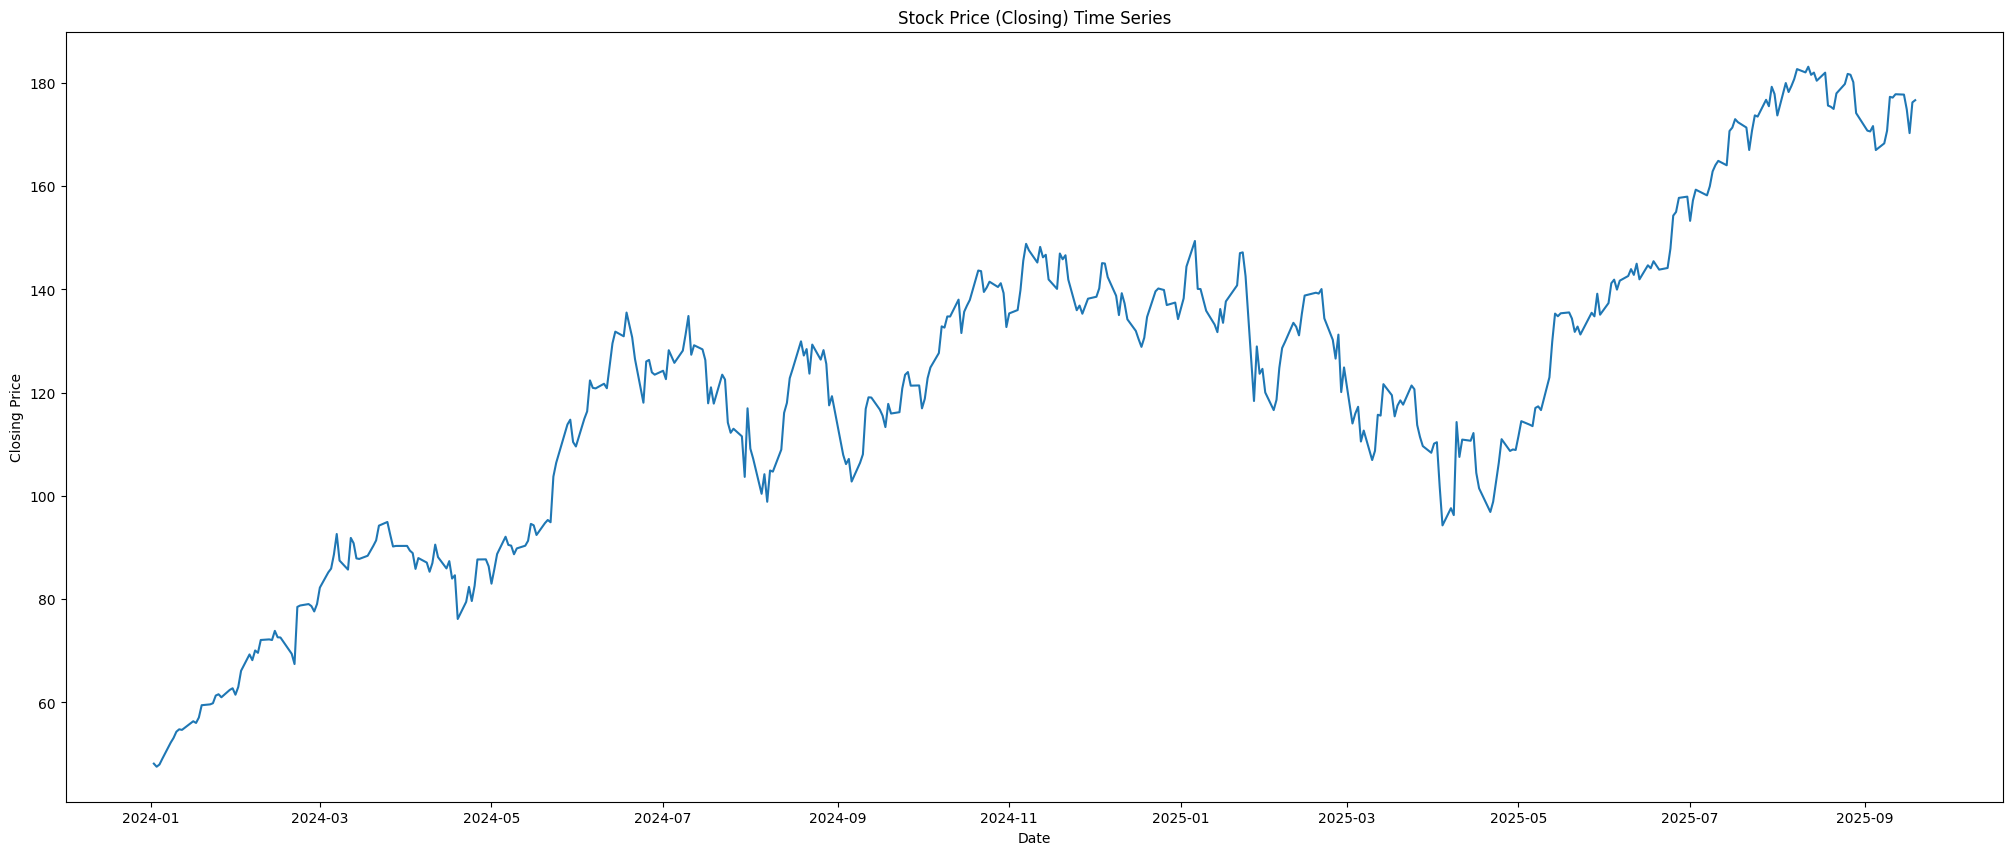

In [6]:
plt.figure(figsize=(25, 10))
plt.plot(data["Close"])
plt.title(f"Stock Price (Closing) Time Series")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.show()

In [7]:
# If data is already a Series, it uses it directly.
# If data is a DataFrame, it selects the Close column and converts it to float64.
ts = data if isinstance(data, pd.Series) else data["Close"].astype('float64')

### Exponential Smoothing

Exponential smoothing is a time series forecasting method for univariate data. It is a weighted average of past observations, with the weights decaying exponentially as the observations get older.

**Note:** Unlike ARIMA models, some exponential smoothing models are designed to handle non-stationary data directly by explicitly modeling trend and seasonality. This is why we can apply them to the original time series.

#### Simple Exponential Smoothing (SES)

- It is normal for Simple Exponential Smoothing (SES) to produce a flat forecast (the same value for all future periods) because it does not model trend or seasonality—only the level. The forecast equals the last estimated level from the fitted model.
- For time series with trend or seasonality, it is better to use Holt’s or Holt-Winters methods instead.

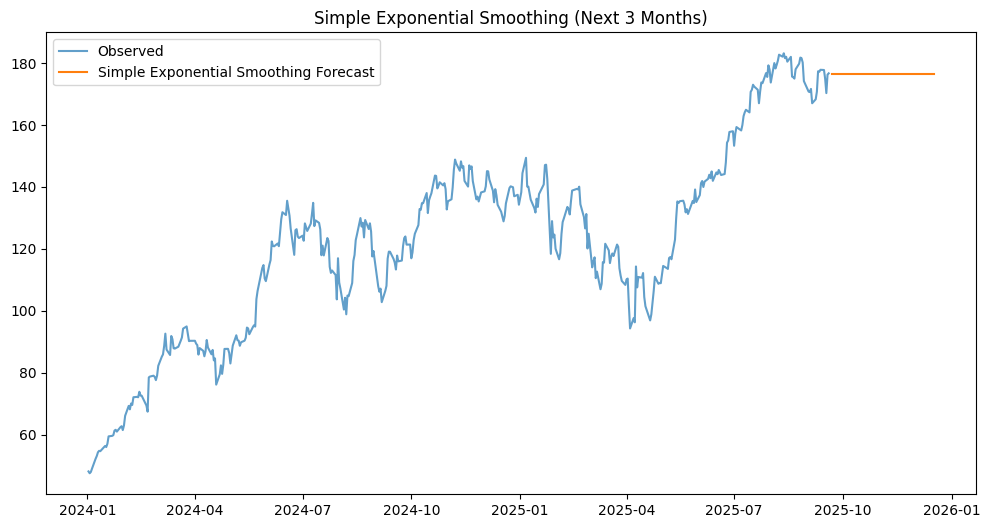

In [8]:
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SimpleExpSmoothing
import pandas as pd

# Fit SES model
model_ses = SimpleExpSmoothing(ts, initialization_method="estimated").fit()

# Forecast next 63 periods
predictions_ses = model_ses.forecast(63)

# Create future index for next 63 periods (e.g., business days)
future_index = pd.date_range(
    start=ts.index[-1] + pd.offsets.BDay(1),
    periods=63,
    freq='B'
)

# Assign index to forecast
predictions_ses = pd.Series(predictions_ses.values, index=future_index)

# Plot observed and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Observed', alpha=0.7)
plt.plot(predictions_ses, label='Simple Exponential Smoothing Forecast')
plt.title('Simple Exponential Smoothing (Next 3 Months)')
plt.legend()
plt.show()

In [9]:
import pandas as pd
predictions_table = pd.DataFrame(predictions_ses)
display(predictions_table)

,0
2025-09-22,176.600057
2025-09-23,176.600057
2025-09-24,176.600057
2025-09-25,176.600057
2025-09-26,176.600057
...,...
2025-12-11,176.600057
2025-12-12,176.600057
2025-12-15,176.600057
2025-12-16,176.600057


#### Double Exponential Smoothing (Holt's Method)

Holt's method is an extension of SES that can handle time series data with a trend.

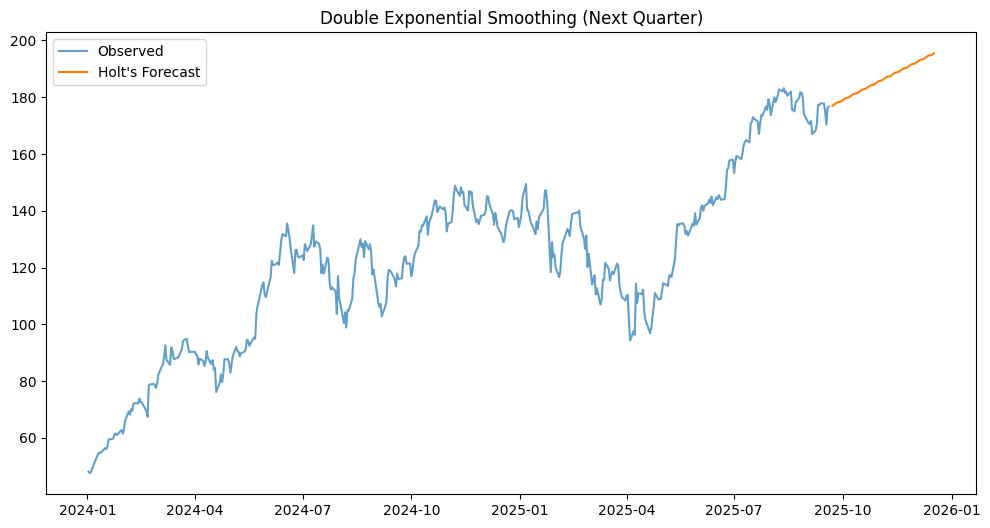

In [10]:
# Python
model_holt = Holt(ts, initialization_method="estimated").fit()
predictions_holt = model_holt.forecast(63)

future_index = pd.date_range(
    start=ts.index[-1] + pd.offsets.BDay(1),  # Use business days if daily data
    periods=63,
    freq='B'
)
predictions_holt = pd.Series(predictions_holt.values, index=future_index)

plt.figure(figsize=(12, 6))
plt.plot(ts, label='Observed', alpha=0.7)
plt.plot(predictions_holt, label="Holt's Forecast")
plt.title("Double Exponential Smoothing (Next Quarter)")
plt.legend()
plt.show()

In [11]:
import pandas as pd
predictions_table = pd.DataFrame(predictions_holt)
display(predictions_table)

,0
2025-09-22,176.918592
2025-09-23,177.217553
2025-09-24,177.516515
2025-09-25,177.815476
2025-09-26,178.114437
...,...
2025-12-11,194.258350
2025-12-12,194.557311
2025-12-15,194.856272
2025-12-16,195.155234


#### Triple Exponential Smoothing (Holt-Winters Method)

The Holt-Winters method extends Holt's method to capture seasonality.

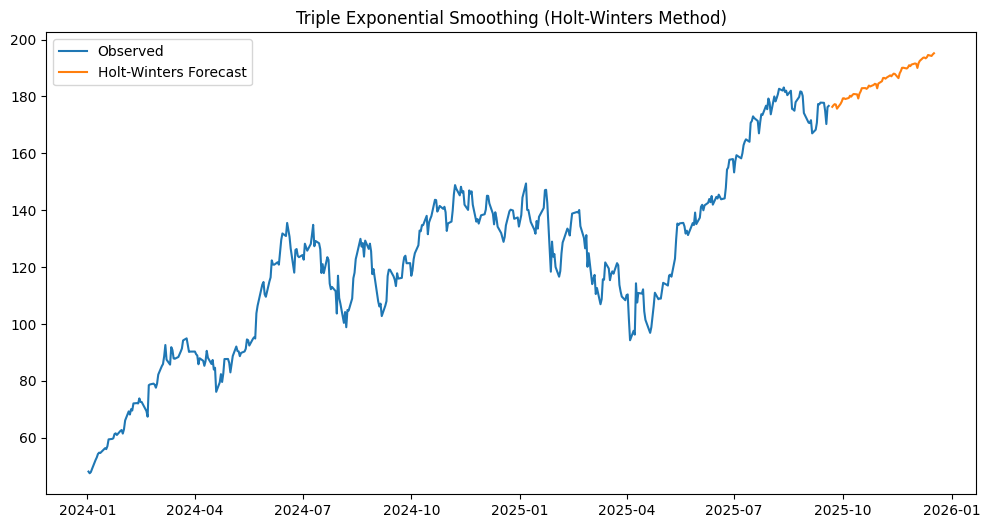

In [12]:
# Python
model_hw = ExponentialSmoothing(ts, seasonal_periods=12, trend='add', seasonal='add', initialization_method="estimated").fit()
predictions_hw = model_hw.forecast(63)

future_index = pd.date_range(
    start=ts.index[-1] + pd.offsets.BDay(1),
    periods=63,  # 63 business days ≈ 3 months
    freq='B'
)
predictions_hw = pd.Series(predictions_hw.values, index=future_index)

plt.figure(figsize=(12, 6))
plt.plot(ts, label='Observed')
plt.plot(predictions_hw, label='Holt-Winters Forecast')
plt.title('Triple Exponential Smoothing (Holt-Winters Method)')
plt.legend()
plt.show()

In [13]:
import pandas as pd
predictions_table = pd.DataFrame(predictions_hw)
display(predictions_table)

,0
2025-09-22,176.330319
2025-09-23,176.883256
2025-09-24,177.271348
2025-09-25,177.141205
2025-09-26,175.689908
...,...
2025-12-11,193.765290
2025-12-12,194.553141
2025-12-15,194.219386
2025-12-16,194.772322


### ARIMA

ARIMA stands for AutoRegressive Integrated Moving Average. It is a class of models that explains a given time series based on its own past values, that is, its own lags and the lagged forecast errors.

An ARIMA model is characterized by 3 parameters: (p, d, q).

* **p:** The number of lag observations included in the model (lag order).
* **d:** The number of times that the raw observations are differenced (degree of differencing).
* **q:** The size of the moving average window (order of moving average).

**Important Note:** You might wonder why we are using the original `data` which is non-stationary. The `statsmodels` implementation of ARIMA is smart. The `d` parameter in the `order=(p,d,q)` argument tells the model how many times to difference the data. So, the model takes care of the differencing internally. This is the standard and recommended way to use ARIMA models in `statsmodels`, as it simplifies the process and automatically returns the forecasts on the original scale.

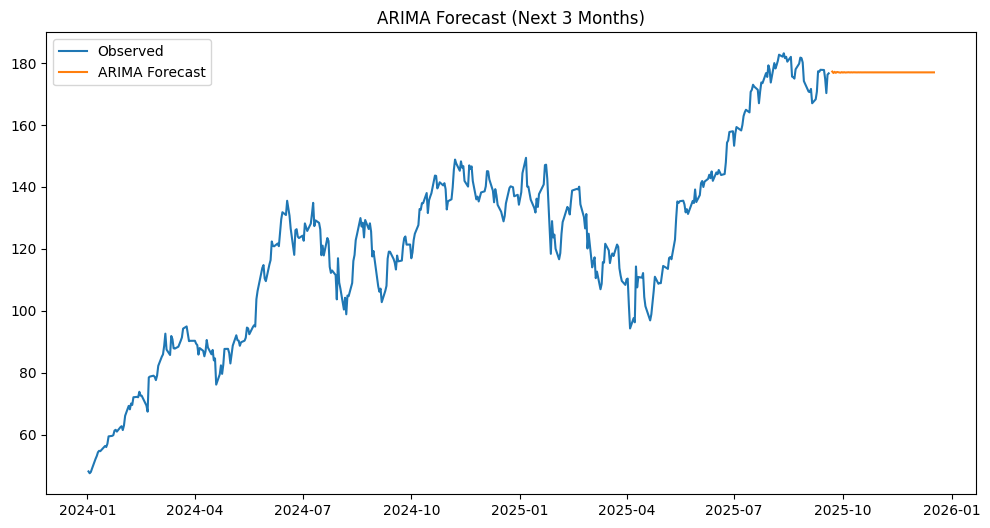

In [14]:
# Python
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import matplotlib.pyplot as plt

# Fit ARIMA model on the closing price series
model_arima = ARIMA(ts, order=(1, 1, 1)).fit()
predictions_arima = model_arima.forecast(steps=63)

# Create a future index for the next 63 business days
future_index = pd.date_range(
    start=ts.index[-1] + pd.offsets.BDay(1),
    periods=63,
    freq='B'
)
predictions_arima = pd.Series(predictions_arima.values, index=future_index)

plt.figure(figsize=(12, 6))
plt.plot(ts, label='Observed')
plt.plot(predictions_arima, label='ARIMA Forecast')
plt.title('ARIMA Forecast (Next 3 Months)')
plt.legend()
plt.show()

In [15]:
import pandas as pd
predictions_table = pd.DataFrame(predictions_arima)
display(predictions_table)

,0
2025-09-22,177.247619
2025-09-23,176.772611
2025-09-24,177.163236
2025-09-25,176.842004
2025-09-26,177.106170
...,...
2025-12-11,176.986966
2025-12-12,176.986960
2025-12-15,176.986965
2025-12-16,176.986961


### SARIMA

SARIMA (Seasonal ARIMA) is an extension of ARIMA that supports time series data with a seasonal component.

A SARIMA model is characterized by 7 parameters: (p, d, q) x (P, D, Q, m).

* **(p, d, q):** The non-seasonal parameters of the ARIMA model.
* **(P, D, Q, m):** The seasonal parameters of the model, where 'm' is the number of time steps for a single seasonal period.

Just like with ARIMA, we use the original time series here and let the model handle the differencing (both seasonal and non-seasonal) for us via the `d` and `D` parameters.

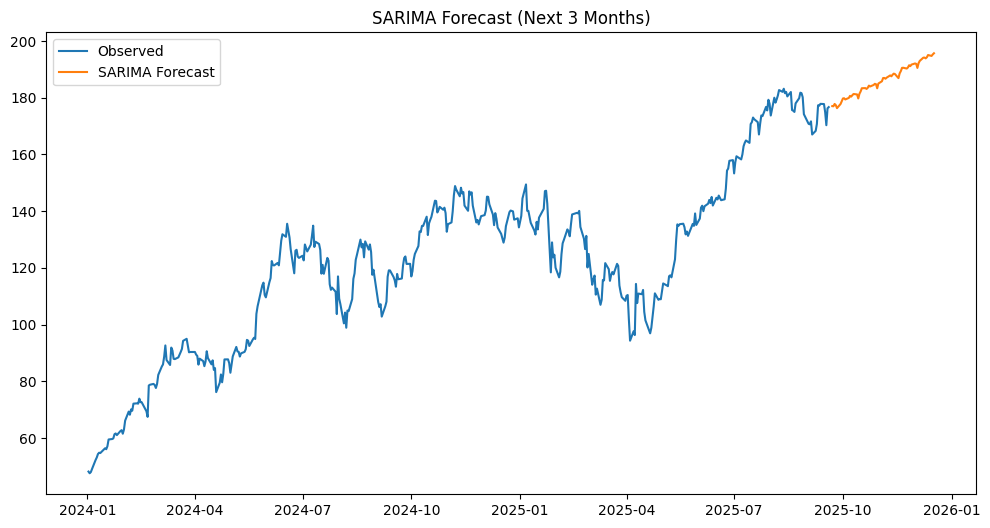

In [16]:
model_sarima = SARIMAX(ts, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
predictions_sarima = model_sarima.forecast(steps=63)

future_index = pd.date_range(
    start=ts.index[-1] + pd.offsets.BDay(1),
    periods=63,
    freq='B'
)
predictions_sarima = pd.Series(predictions_sarima.values, index=future_index)

plt.figure(figsize=(12, 6))
plt.plot(ts, label='Observed')
plt.plot(predictions_sarima, label='SARIMA Forecast')
plt.title('SARIMA Forecast (Next 3 Months)')
plt.legend()
plt.show()


In [17]:
import pandas as pd
predictions_table = pd.DataFrame(predictions_sarima)
display(predictions_table)

,0
2025-09-22,177.018920
2025-09-23,176.965290
2025-09-24,177.781417
2025-09-25,177.365997
2025-09-26,176.305022
...,...
2025-12-11,194.244848
2025-12-12,195.032042
2025-12-15,194.718589
2025-12-16,195.254123


### Prophet

- Resetting the index is necessary when preparing data for Prophet because Prophet expects a DataFrame with two columns:
    - ds (date/time column)
    - y (value column)
- If your time series uses the date as the index, resetting the index moves the date from the index into a column, making it accessible for Prophet.
- This ensures the DataFrame has the required structure for Prophet to fit and forecast.

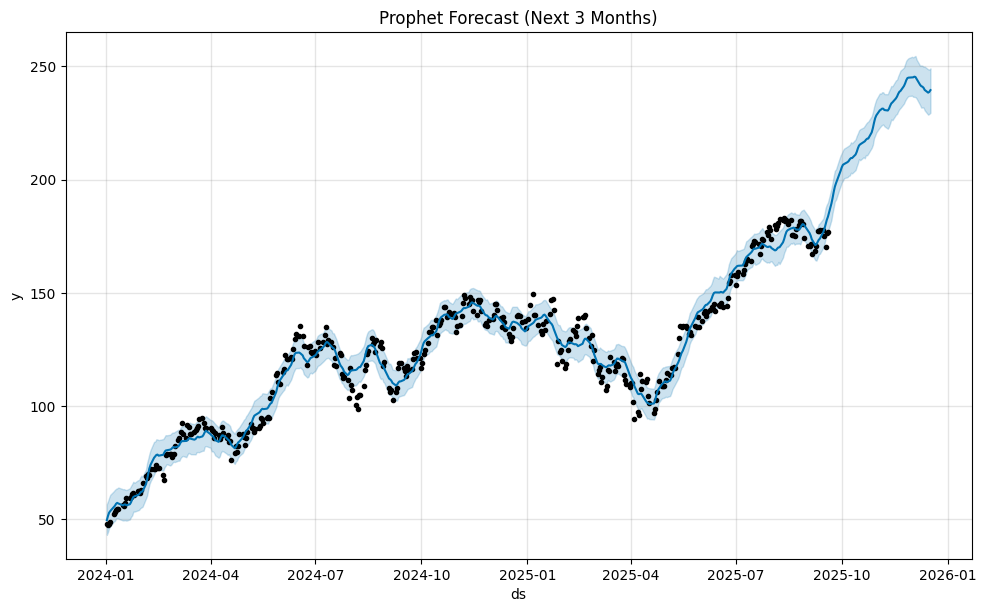

In [32]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Prepare data for Prophet
df_prophet = ts.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
df_prophet.columns = ['ds', 'y']  # Ensure correct column names

# Define holidays
holidays = pd.DataFrame({
    'holiday': ['new_year', 'christmas'],
    'ds': pd.to_datetime(['2023-01-01', '2023-12-25'])
})

# Initialize Prophet with custom settings
tf_prophet_model = Prophet(
    holidays=holidays,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)
tf_prophet_model.add_seasonality(name='quarterly', period=63, fourier_order=5)

# Fit Prophet model
tf_prophet_model.fit(df_prophet)

# Create future DataFrame for the next 63 business days
future = tf_prophet_model.make_future_dataframe(periods=63, freq='B')

# Forecast
forecast = tf_prophet_model.predict(future)

# Plot forecast
fig = tf_prophet_model.plot(forecast)
plt.title('Prophet Forecast (Next 3 Months)')
plt.show()

- The DataFrame returned by Prophet's predict method contains the following columns:
    - ds: The datestamp for each prediction.
    - yhat: The predicted value (forecast) for each date.
    - yhat_lower: The lower bound of the uncertainty interval for the forecast.
    - yhat_upper: The upper bound of the uncertainty interval for the forecast.
    - trend: The estimated trend component.
    - trend_lower / trend_upper: Lower/upper bounds for the trend.
    - additive_terms: Sum of all additive components (seasonality, holidays, etc.).
    - additive_terms_lower / additive_terms_upper: Bounds for additive terms.
    - weekly, yearly, daily, holidays: Seasonality and holiday components (if modeled).
    - weekly_lower / weekly_upper, etc.: Bounds for each seasonal/holiday component.

- Not all columns appear if certain components (like holidays or specific seasonalities) are not included in the model. The most important column for predictions is yhat.

In [30]:
import pandas as pd
predictions_table = pd.DataFrame(forecast)
display(predictions_table)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,christmas,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-01-02,36.956857,42.506076,56.421446,36.956857,36.956857,12.744960,12.744960,12.744960,0.0,...,-2.488332,-2.488332,-2.488332,11.380053,11.380053,11.380053,0.0,0.0,0.0,49.701816
1,2024-01-03,37.738891,45.001862,58.085328,37.738891,37.738891,13.824263,13.824263,13.824263,0.0,...,-1.945787,-1.945787,-1.945787,11.594324,11.594324,11.594324,0.0,0.0,0.0,51.563155
2,2024-01-04,38.520926,46.393801,59.722030,38.520926,38.520926,14.480160,14.480160,14.480160,0.0,...,-1.728810,-1.728810,-1.728810,11.824921,11.824921,11.824921,0.0,0.0,0.0,53.001086
3,2024-01-05,39.302960,46.809682,60.213216,39.302960,39.302960,14.395834,14.395834,14.395834,0.0,...,-2.111926,-2.111926,-2.111926,12.062143,12.062143,12.062143,0.0,0.0,0.0,53.698794
4,2024-01-08,41.649064,48.622157,61.837156,41.649064,41.649064,13.741391,13.741391,13.741391,0.0,...,-2.675119,-2.675119,-2.675119,12.717049,12.717049,12.717049,0.0,0.0,0.0,55.390455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,2025-12-11,228.154866,230.821334,249.890608,221.675510,234.432756,12.335805,12.335805,12.335805,0.0,...,-1.728810,-1.728810,-1.728810,17.441610,17.441610,17.441610,0.0,0.0,0.0,240.490671
490,2025-12-12,228.555020,230.258872,249.235597,221.936991,235.013171,10.972167,10.972167,10.972167,0.0,...,-2.111926,-2.111926,-2.111926,16.946208,16.946208,16.946208,0.0,0.0,0.0,239.527187
491,2025-12-15,229.755484,229.309411,248.575124,222.976537,236.363642,8.583566,8.583566,8.583566,0.0,...,-2.675119,-2.675119,-2.675119,15.325924,15.325924,15.325924,0.0,0.0,0.0,238.339050
492,2025-12-16,230.155639,228.342304,248.340455,223.260196,236.861197,8.517474,8.517474,8.517474,0.0,...,-2.488332,-2.488332,-2.488332,14.769898,14.769898,14.769898,0.0,0.0,0.0,238.673112


## New LSTM
LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) designed to learn from sequential data, making it well-suited for time series forecasting.
TensorFlow (with Keras) is a widely used framework for building LSTM and other neural networks. It is a good starting point for time series forecasting with LSTM.
Below is a simple baseline example for LSTM time series forecasting using TensorFlow/Keras:
Explanation:
The code scales the data, creates input sequences, splits into train/test, builds a simple LSTM model, trains it, and forecasts future values.

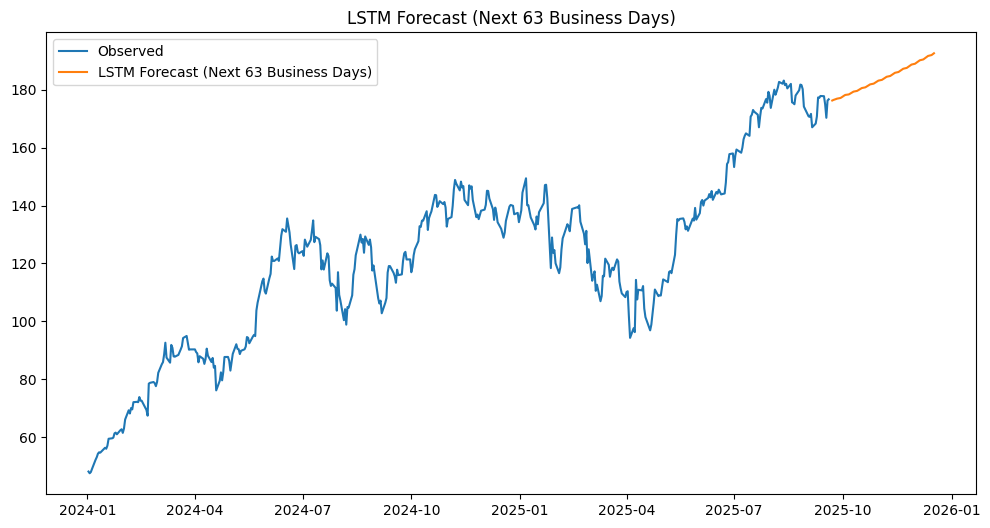

,LSTM Forecast
2025-09-22,176.256149
2025-09-23,176.452179
2025-09-24,176.596802
2025-09-25,176.737656
2025-09-26,176.897354
...,...
2025-12-11,191.343216
2025-12-12,191.647476
2025-12-15,191.953110
2025-12-16,192.260101


In [20]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# --- Baseline LSTM using ts ---

window_size = 12

# Scale the data
scaler = MinMaxScaler()
scaled_ts = scaler.fit_transform(ts.values.reshape(-1, 1))

# Create sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, 0])
        y.append(data[i+window_size, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_ts, window_size)
X = X.reshape((X.shape[0], window_size, 1))

# Build and train LSTM model
model = Sequential([
    LSTM(50, activation='tanh', input_shape=(window_size, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=30, batch_size=16, validation_split=0.1, verbose=0)

# Forecast next 63 business days
last_sequence = scaled_ts[-window_size:].reshape(1, window_size, 1)
future_preds_scaled = []
for _ in range(63):
    pred = model.predict(last_sequence, verbose=0)
    future_preds_scaled.append(pred[0, 0])
    last_sequence = np.concatenate([last_sequence[:, 1:, :], pred.reshape(1, 1, 1)], axis=1)

future_preds = scaler.inverse_transform(np.array(future_preds_scaled).reshape(-1, 1)).flatten()
future_index = pd.date_range(start=ts.index[-1] + pd.offsets.BDay(1), periods=63, freq='B')

# --- Plot forecast (like SARIMA) ---
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Observed')
plt.plot(future_index, future_preds, label='LSTM Forecast (Next 63 Business Days)')
plt.title('LSTM Forecast (Next 63 Business Days)')
plt.legend()
plt.show()

# --- Display forecasted data in a table ---
forecast_table = pd.DataFrame({'LSTM Forecast': future_preds}, index=future_index)
display(forecast_table)

In [21]:
import pandas as pd

# Assuming 'forecast' is the output from Prophet's predict method
predictions_table = pd.DataFrame(forecast)
display(predictions_table)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-01-02,54.561020,44.217732,67.208937,54.561020,54.561020,1.063097,1.063097,1.063097,1.063097,1.063097,1.063097,0.0,0.0,0.0,55.624118
1,2024-01-03,54.901395,44.877249,68.393267,54.901395,54.901395,1.485711,1.485711,1.485711,1.485711,1.485711,1.485711,0.0,0.0,0.0,56.387106
2,2024-01-04,55.241770,45.532371,67.920894,55.241770,55.241770,1.605814,1.605814,1.605814,1.605814,1.605814,1.605814,0.0,0.0,0.0,56.847584
3,2024-01-05,55.582144,44.440264,68.673709,55.582144,55.582144,1.531231,1.531231,1.531231,1.531231,1.531231,1.531231,0.0,0.0,0.0,57.113375
4,2024-01-08,56.603268,46.048847,69.134738,56.603268,56.603268,0.938475,0.938475,0.938475,0.938475,0.938475,0.938475,0.0,0.0,0.0,57.541743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,2025-12-11,229.467012,217.714421,244.295862,222.663057,236.059466,1.605814,1.605814,1.605814,1.605814,1.605814,1.605814,0.0,0.0,0.0,231.072826
490,2025-12-12,229.953060,218.010124,244.450549,222.885734,236.624766,1.531231,1.531231,1.531231,1.531231,1.531231,1.531231,0.0,0.0,0.0,231.484291
491,2025-12-15,231.411207,218.033965,245.710706,224.160068,238.265195,0.938475,0.938475,0.938475,0.938475,0.938475,0.938475,0.0,0.0,0.0,232.349682
492,2025-12-16,231.897256,219.126229,246.309188,224.479843,238.965318,1.063097,1.063097,1.063097,1.063097,1.063097,1.063097,0.0,0.0,0.0,232.960353


### Perform some hyperparameter tuning

,LSTM_units=32_lr=0.01_ep=40_batch=16,LSTM_units=64_lr=0.005_ep=50_batch=32,LSTM_units=100_lr=0.001_ep=60_batch=16
2025-09-22,177.068558,175.614471,174.932953
2025-09-23,177.049469,176.386673,175.092957
2025-09-24,176.794510,176.685577,175.143799
2025-09-25,176.546005,176.821091,175.133789
2025-09-26,176.328400,176.910965,175.085754
...,...,...,...
2025-12-11,170.705017,182.347366,170.493607
2025-12-12,170.636902,182.433243,170.403351
2025-12-15,170.569702,182.518539,170.312927
2025-12-16,170.503387,182.603302,170.222321


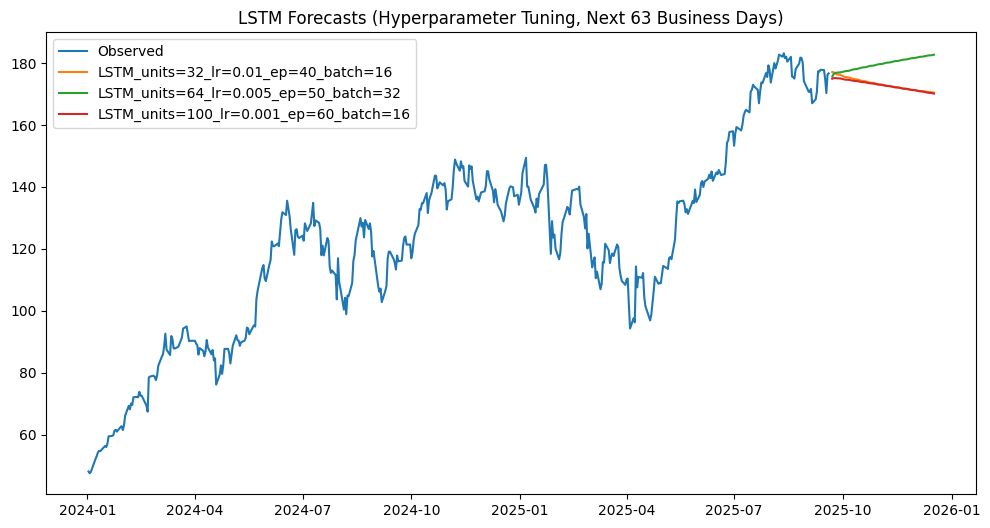

In [22]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# --- Data Preparation ---
window_size = 12
scaler = MinMaxScaler()
scaled_ts = scaler.fit_transform(ts.values.reshape(-1, 1))

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, 0])
        y.append(data[i+window_size, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_ts, window_size)
X = X.reshape((X.shape[0], window_size, 1))

# --- Hyperparameter Grid ---
hyperparams = [
    {'units': 32, 'lr': 0.01, 'epochs': 40, 'batch': 16},
    {'units': 64, 'lr': 0.005, 'epochs': 50, 'batch': 32},
    {'units': 100, 'lr': 0.001, 'epochs': 60, 'batch': 16}
]

results = {}
for params in hyperparams:
    model = Sequential([
        LSTM(params['units'], activation='tanh', input_shape=(window_size, 1)),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=params['lr']), loss='mse')
    model.fit(X, y, epochs=params['epochs'], batch_size=params['batch'], validation_split=0.1, verbose=0)
    # Forecast next 63 business days
    last_seq = scaled_ts[-window_size:].reshape(1, window_size, 1)
    preds_scaled = []
    for _ in range(63):
        pred = model.predict(last_seq, verbose=0)
        preds_scaled.append(pred[0, 0])
        last_seq = np.concatenate([last_seq[:, 1:, :], pred.reshape(1, 1, 1)], axis=1)
    preds = scaler.inverse_transform(np.array(preds_scaled).reshape(-1, 1)).flatten()
    key = f"LSTM_units={params['units']}_lr={params['lr']}_ep={params['epochs']}_batch={params['batch']}"
    results[key] = preds

# --- Display Results ---
future_index = pd.date_range(start=ts.index[-1] + pd.offsets.BDay(1), periods=63, freq='B')
results_df = pd.DataFrame(results, index=future_index)
display(results_df)

plt.figure(figsize=(12, 6))
plt.plot(ts, label='Observed')
for col in results_df.columns:
    plt.plot(results_df.index, results_df[col], label=col)
plt.title('LSTM Forecasts (Hyperparameter Tuning, Next 63 Business Days)')
plt.legend()
plt.show()

## Using your GPU with TensorFlow
To ensure you have compatible NVIDIA drivers and CUDA/cuDNN installed for TensorFlow GPU support:
1. Check your GPU model:
Run nvidia-smi in the terminal to see your GPU and driver version.
2. Install the latest NVIDIA driver:
Download and install the latest driver for your GPU from the NVIDIA Driver Downloads page.
3. Check TensorFlow compatibility:
Refer to the TensorFlow GPU support guide for the required CUDA and cuDNN versions for your TensorFlow release.
4. Install CUDA Toolkit:
Download the correct CUDA version from the NVIDIA CUDA Toolkit.
5. Install cuDNN:
Download the matching cuDNN version from the NVIDIA cuDNN Archive.
6. Add CUDA and cuDNN to your PATH:
Add the bin and lib folders of CUDA and cuDNN to your system environment variables.
7. Verify installation:
Run the following in Python to check if TensorFlow detects your GPU:

In [25]:
import tensorflow as tf
print("Number of usable NVIDIA GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Number of usable NVIDIA GPUs Available: 0


In [28]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Check GPU availability
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
assert len(tf.config.list_physical_devices('GPU')) > 0, "No usable NVIDIA GPU found."

window_size = 12
scaler = MinMaxScaler()
scaled_ts = scaler.fit_transform(ts.values.reshape(-1, 1))

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, 0])
        y.append(data[i+window_size, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_ts, window_size)
X = X.reshape((X.shape[0], window_size, 1))

hyperparams = [
    {'units': 32, 'lr': 0.01, 'epochs': 40, 'batch': 16},
    {'units': 64, 'lr': 0.005, 'epochs': 50, 'batch': 32},
    {'units': 100, 'lr': 0.001, 'epochs': 60, 'batch': 16}
]

results = {}
with tf.device('/GPU:0'):
    for params in hyperparams:
        model = Sequential([
            LSTM(params['units'], activation='tanh', input_shape=(window_size, 1)),
            Dense(1)
        ])
        model.compile(optimizer=Adam(learning_rate=params['lr']), loss='mse')
        model.fit(X, y, epochs=params['epochs'], batch_size=params['batch'], validation_split=0.1, verbose=0)
        # Forecast next 63 business days
        last_seq = scaled_ts[-window_size:].reshape(1, window_size, 1)
        preds_scaled = []
        for _ in range(63):
            pred = model.predict(last_seq, verbose=0)
            preds_scaled.append(pred[0, 0])
            last_seq = np.concatenate([last_seq[:, 1:, :], pred.reshape(1, 1, 1)], axis=1)
        preds = scaler.inverse_transform(np.array(preds_scaled).reshape(-1, 1)).flatten()
        key = f"LSTM_units={params['units']}_lr={params['lr']}_ep={params['epochs']}_batch={params['batch']}"
        results[key] = preds

future_index = pd.date_range(start=ts.index[-1] + pd.offsets.BDay(1), periods=63, freq='B')
results_df = pd.DataFrame(results, index=future_index)
display(results_df)

plt.figure(figsize=(12, 6))
plt.plot(ts, label='Observed')
for col in results_df.columns:
    plt.plot(results_df.index, results_df[col], label=col)
plt.title('LSTM Forecasts (GPU, Hyperparameter Tuning, Next 63 Business Days)')
plt.legend()
plt.show()

Num GPUs Available: 0


AssertionError: No usable NVIDIA GPU found.